# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data.
TODO:
- Cross Validation implementation


In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
import torch
import torch.optim as optim
import seaborn as sns

# Import data

In [164]:
### Load the data
seed = 50
data_path = 'data/output/data_complete_2022-06-13.csv'
df = pd.read_csv(data_path)

# Scale Data

In [179]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
M = scaler.fit_transform(df)
y = M[:,-1]
X = M[:,:-1]

# Train

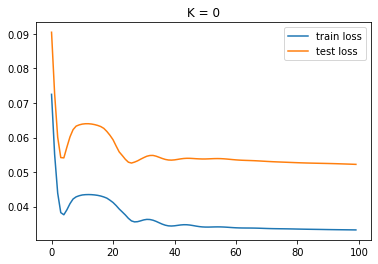

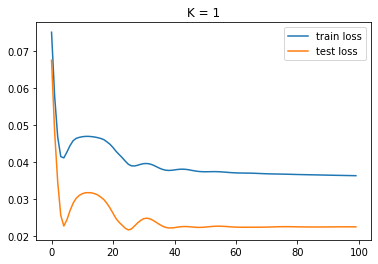

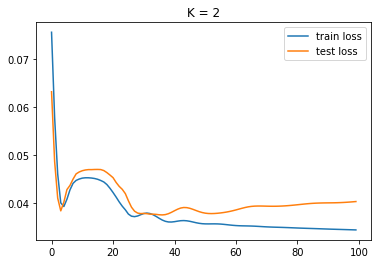

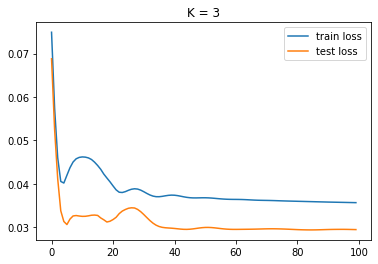

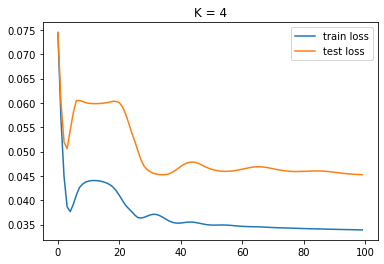

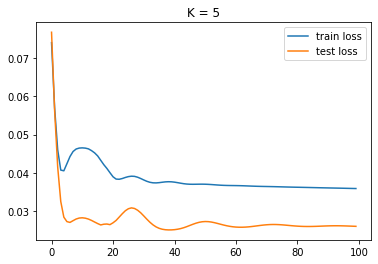

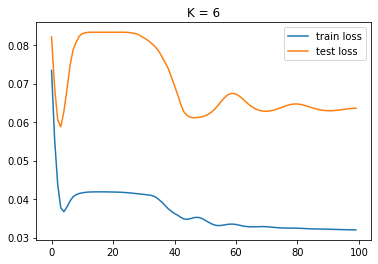

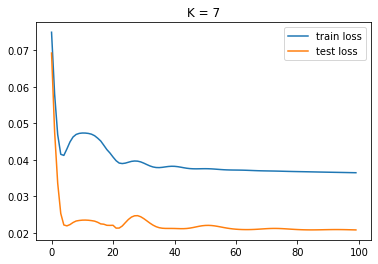

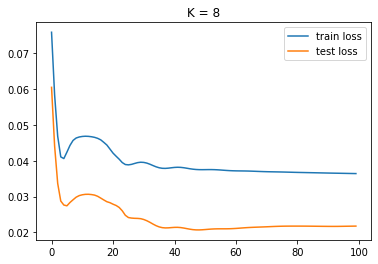

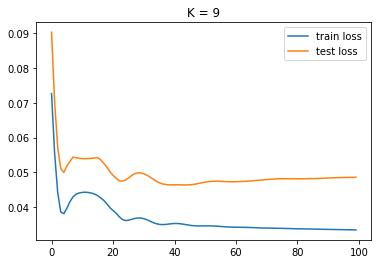

In [200]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

error = []
# Test split using K-Folds cross-validator
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    # Slicing data according to kf split
    dtype = torch.float
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    x_train = torch.tensor(x_train,dtype=dtype)
    x_test = torch.tensor(x_test, dtype=dtype)
    y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
    y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)

    # Hyper-parameters for one train test session
    epochs = 100
    torch.manual_seed(seed)
    method = NN(input_size=x_train.shape[1])
    criterion = nn.MSELoss()
    params_to_be_optimized = method.get_parameters()
    optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
    scheduler = ExponentialLR(optimizer, gamma=0.999)
    train_losses = []  # for plot
    test_losses = []  # for plot

    for epoch in range(epochs):
      iteration_time = time.time()
      optimizer.zero_grad()

      # forward pass
      y_train_predicted = method.predict(x_train)
      loss = criterion(y_train_predicted, y_train)

      # backward pass
      loss.backward()
      optimizer.step()
      scheduler.step()

      with torch.no_grad():
        y_train_predicted = method.predict(x_train)
        train_loss = criterion(y_train_predicted, y_train)
        train_losses.append(train_loss)

        y_test_predicted = method.predict(x_test)
        test_loss = criterion(y_test_predicted, y_test)
        test_losses.append(test_loss)


    error += np.abs(y_test.detach().numpy() - method.predict(x_test).detach().numpy()).tolist()
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.title(f'K = {idx}')
    plt.show()

# Test results

/home/anuar/PycharmProjects/termische_comfort/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


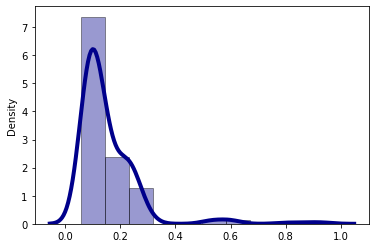

In [205]:
# Density Plot and Histogram of all arrival delays
sns.distplot(error, hist=True, kde=True,
             bins=10, color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

# Extra

In [170]:
# Rescale test result to original values
zeros = np.zeros(x_test.shape)
test_predicted = np.concatenate((zeros, method.predict(x_test).detach().numpy()),axis=1)
test_predicted= scaler.inverse_transform(test_predicted)[:,-1]

test_target = np.concatenate((zeros, y_test.detach().numpy()),axis=1)
test_target = scaler.inverse_transform(test_target)[:,-1]

In [171]:
# Calculate percentage error
percentage_error = np.abs((test_target - test_predicted))

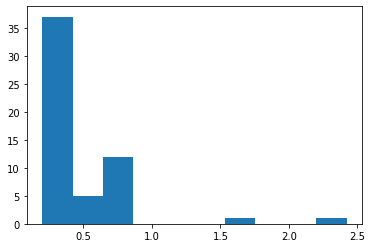

In [172]:
# Plot histogram of percentage error
plt.hist(percentage_error)
plt.show()